In [78]:
rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,archive,gt)
font_add_google("Poppins", "pop")
showtext_auto()

In [79]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [80]:
url_basica <- "https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte <- "microdatos/enigh"
years <- c("2016", "2018", "2020", "2022","2024")
tipos <- c("ns_viviendas", "ns_concentradohogar")

In [81]:
for (i in seq_along(years)) {
  for (tipo in tipos) {
    fin <- paste0("_", tipo, "_csv.zip")
    url <- paste0(url_basica, years[i], "/", segunda_parte, years[i], fin)
    destfile <- paste0("data/", years[i], fin)
    
    # Descargar archivo zip
    download.file(url, destfile = destfile)

    # Crear carpeta temporal de extracción (por año y tipo)
    carpeta_temporal <- paste0("data/tmp_", tipo, "_", years[i])
    dir.create(carpeta_temporal, showWarnings = FALSE)
    
    # Descomprimir en la carpeta temporal
    unzip(destfile, exdir = carpeta_temporal)

    # Detectar archivo .csv en la carpeta temporal
    archivos_csv <- list.files(carpeta_temporal, pattern = "\\.csv$", full.names = TRUE)
    
    if (length(archivos_csv) == 1) {
      # Eliminar prefijo "ns_" si existe
      tipo_limpio <- sub("^ns_", "", tipo)
      nombre_destino <- paste0("data/", tipo_limpio, "_", years[i], ".csv")
      file.rename(archivos_csv, nombre_destino)
    } else {
      warning(paste("No se encontró archivo .csv único en:", carpeta_temporal))
    }

    # Eliminar carpeta temporal después de mover
    unlink(carpeta_temporal, recursive = TRUE)
  }
}


In [82]:
estimacion <- function(path, variable) {
  # Cargar los datos
  print(path)
  datos <- read_csv(path, show_col_types=FALSE)

  datos <- datos %>%
    mutate(
      across(starts_with("mat") & where(is.character),
             ~ replace_na(parse_number(.x, na = c('', 'NA', '&')), 0)),
      rezago = if_else(
        ((tot_resid / num_cuarto) > 2.5) |
          (mat_pared %in% 1:6) |
          (mat_techos %in% c(1:4, 6, 7, 9)) |
          (mat_pisos == 1) |
          (excusado == 2),
        "En rezago",
        "Fuera de rezago"
      )
    ) %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ),
    #Crear nombre de entidad
    nom_ent=case_when(
      cve_ent == "01" ~ "Aguascalientes",
      cve_ent == "02" ~ "Baja California",
      cve_ent == "03" ~ "Baja California Sur",
      cve_ent == "04" ~ "Campeche",
      cve_ent == "05" ~ "Chiapas",
      cve_ent == "06" ~ "Chihuahua",
      cve_ent == "07" ~ "Coahuila",
      cve_ent == "08" ~ "Colima",
      cve_ent == "09" ~ "Ciudad de México",
      cve_ent == "10" ~ "Durango",
      cve_ent == "11" ~ "Guanajuato",
      cve_ent == "12" ~ "Guerrero",
      cve_ent == "13" ~ "Hidalgo",
      cve_ent == "14" ~ "Jalisco",
      cve_ent == "15" ~ "México",
      cve_ent == "16" ~ "Michoacán",
      cve_ent == "17" ~ "Morelos",
      cve_ent == "18" ~ "Nayarit",
      cve_ent == "19" ~ "Nuevo León",
      cve_ent == "20" ~ "Oaxaca",
      cve_ent == "21" ~ "Puebla",
      cve_ent == "22" ~ "Querétaro Arteaga",
      cve_ent == "23" ~ "Quintana Roo",
      cve_ent == "24" ~ "San Luis Potosí",
      cve_ent == "25" ~ "Sinaloa",
      cve_ent == "26" ~ "Sonora",
      cve_ent == "27" ~ "Tabasco",
      cve_ent == "28" ~ "Tamaulipas",
      cve_ent == "29" ~ "Tlaxcala",
      cve_ent == "30" ~ 	"Veracruz", 
      cve_ent == "31" ~ "Yucatán",
      cve_ent == "32" ~ "Zacatecas",
      TRUE 	~ NA_character_
    )) 


  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)




  # Devolver el resultado basado en la variable
  if (variable == "rezago") {
     # Estimar rezago habitacional
  rezago <- mydesign %>%
    group_by(rezago) %>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")
        #Viviendas totales
    ) %>%
    mutate(pct = round(pct * 100, 2)) %>%

    # Añadir año
    mutate(year = substr(path, 16, 19))

  return(rezago)

  }

  else if (variable =="rezago_ent") {
    # Estimar rezago por entidad
    rezago_ent <- mydesign %>%
      group_by(nom_ent, rezago) %>%
      summarise(
        viviendas = survey_total(vartype = "cv"),
        pct = survey_prop(vartype = "cv")
      ) %>%
      mutate(pct = round(pct * 100, 2)) %>%
      ungroup() %>%
      filter(rezago == "En rezago") %>%
      mutate(year = substr(path, 16, 19))

    return(rezago_ent)

  } 

else {
    stop("Variable no reconocida. Use 'rezago' o 'rezago_ent'.")
  }}

In [83]:
archivosviv<-list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv")
archivoshog<- list.files("data", full.names = TRUE, pattern = "concentradohogar_.*.csv")

#### Rezago total

In [84]:
#Estimar rezago del último archivo
estimacion(tail(archivosviv, 1), "rezago") %>%
#Eliminar columnas innecesarias viviendas_se, prop_se
    select(rezago,viviendas,pct)%>%
    janitor::adorn_totals("row")%>%
    #Viviendas con big.mark
    mutate(viviendas=scales::comma(viviendas, big.mark = ","))%>%
     gt()%>%
tab_options(table.font.names = 'Poppins',
source_notes.font.size = 8
)%>%
 tab_header(title=md("**Rezago habitacional en México, 2024**"),
               subtitle=md("*(Número de viviendas y porcentaje)*"))%>%


    cols_label(rezago=md("**Condición**"),
                viviendas=md("**Viviendas**"),
                pct=md("**Porcentaje**"))%>%
                cols_align(align="center")%>%
    tab_source_note(
      md("Fuente: @claudiodanielpc con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2024."))%>%
      #Eliminar bordes arriba y abajo
      tab_options(table.border.top.width = px(0),
                  table.border.bottom.width = px(0))%>%
  tab_options(column_labels.background.color = "#9F2241")%>%
  #Salvar tabla
  gtsave("rezago2024.png")

[1] "data/viviendas_2024.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


In [85]:
hogares <- read_csv(tail(archivoshog, 1), show_col_types = FALSE) %>%
  left_join(
    read_csv(tail(archivosviv, 1), show_col_types = FALSE)%>%
    #Estima rezago habitacional
    mutate(
      across(starts_with("mat") & where(is.character),
             ~ replace_na(parse_number(.x, na = c('', 'NA', '&')), 0)),
      rezago = if_else(
        ((tot_resid / num_cuarto) > 2.5) |
          (mat_pared %in% 1:6) |
          (mat_techos %in% c(1:4, 6, 7, 9)) |
          (mat_pisos == 1) |
          (excusado == 2),
        "En rezago",
        "Fuera de rezago"
      )
    ) %>%
    select(folioviv, rezago))%>%
    #Calcular deciles de ingreso
    #Ordenar por ingreso
    arrange(desc(ing_cor))%>%
    #Crear deciles
    mutate(decil = ntile(ing_cor, 10))


hogares %>%
  #Definir diseño muestral
  as_survey_design(ids = upm,
                   strata = est_dis,
                   weights = factor)%>%
  group_by(rezago, decil) %>%
  summarise(
    hogares = survey_total(vartype = "cv"),
  ) %>%
  ungroup() %>%
  filter(rezago == "En rezago") %>%
  mutate(pct= round(hogares / sum(hogares) * 100,1))%>%
  select(decil, hogares, pct) %>%
  janitor::adorn_totals("row") %>%
  mutate(hogares = scales::comma(hogares, big.mark = ",")) %>%
mutate(
  decil = ifelse(row_number() == n(), "-", as.character(decil)),
  pct = ifelse(row_number() == n(), 100, as.character(pct)))%>%
  #Sustituir deciles por números romanos
  mutate(decil = case_when(
    decil == "1" ~ "I",
    decil == "2" ~ "II",
    decil == "3" ~ "III",
    decil == "4" ~ "IV",
    decil == "5" ~ "V",
    decil == "6" ~ "VI",
    decil == "7" ~ "VII",
    decil == "8" ~ "VIII",
    decil == "9" ~ "IX",
    decil == "10" ~ "X",
    TRUE ~ "Total"
  ))->tabla_deciles

tabla_deciles %>%
  gt() %>%
  tab_options(table.font.names = 'Poppins',
              source_notes.font.size = 8) %>%
  tab_header(title = md("**Hogares que habitan en viviendas con rezago habitacional por decil de ingreso, 2024**"),
             subtitle = md("*(Número de hogares y porcentaje)*")) %>%
  cols_label(decil = md("**Decil de ingreso**"),
                hogares = md("**Hogares**"),
                pct = md("**Porcentaje**")) %>%
  cols_align(align = "center") %>%
    tab_source_note(
    md("Nota: El total puede no coincidir con la suma de los parciales por efecto de redondeo.")
  ) %>%
  tab_source_note(
    md("Fuente: @claudiodanielpc con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2024.")) %>%
  #Eliminar bordes arriba y abajo
  tab_options(table.border.top.width = px(0),
              table.border.bottom.width = px(0)) %>%
  tab_options(column_labels.background.color = "#9F2241") %>%
  #Salvar tabla
  gtsave("rezago2024_deciles.png")

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Joining with `by = join_by(folioviv)`


In [86]:
#Sumar pct de los 3 primeros deciles
tabla_deciles %>%
  filter(decil %in% c("I", "II", "III")) %>%
  summarise(pct = sum(as.numeric(pct)))

pct
<dbl>
49.6


#### Rezago histórico

In [87]:
tabla_rezago<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  
  estimacion,
  variable = "rezago"
)%>%
mutate(year = as.integer(year))%>%
filter(rezago=="En rezago")
print("Porcentaje de viviendas cuyos habitantes viven en rezago habitacional")
tabla_rezago

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2024.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Porcentaje de viviendas cuyos habitantes viven en rezago habitacional"


rezago,viviendas,viviendas_cv,pct,pct_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
En rezago,9023373,0.01203622,27.86,0.01141591,2016
En rezago,9238897,0.01220267,27.32,0.01169431,2018
En rezago,8867223,0.01113287,25.17,0.01050622,2020
En rezago,8977409,0.01108010,24.28,0.01054548,2022
En rezago,8734065,0.01314195,22.77,0.01224379,2024


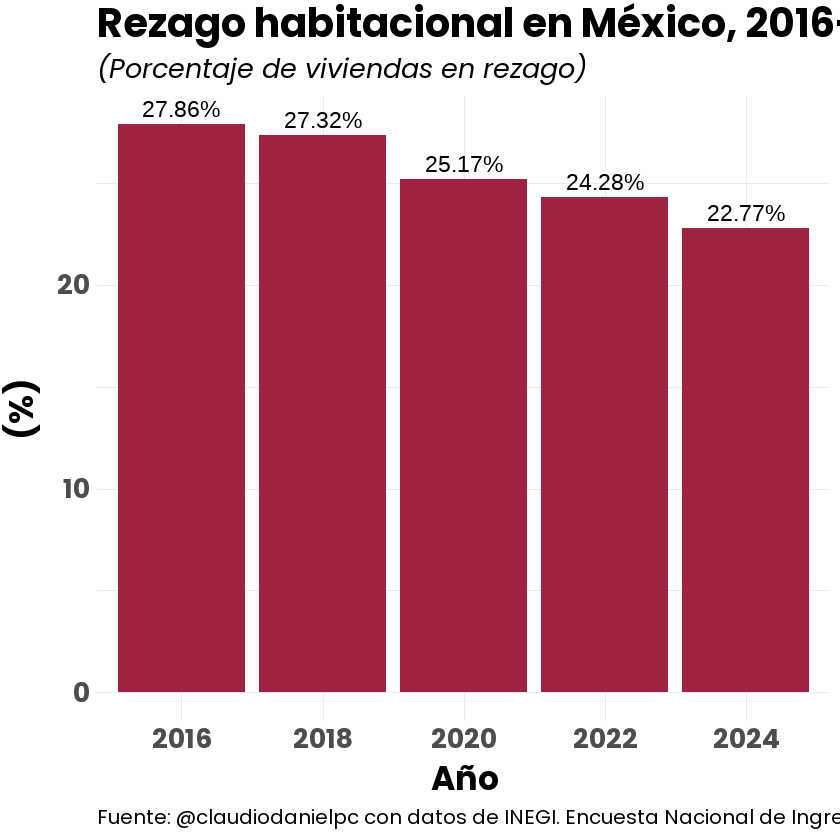

In [106]:
tabla_rezago%>%
#Gráfica de barras

ggplot(aes(x = factor(year), y = pct)) +
  geom_col(fill = "#9F2241") +
  geom_text(
    aes(label = paste0(round(pct, 2), "%")),
    hjust = 0.5,
    vjust= -0.5,
    size = 6,
    color = "black"
  ) +
  labs(
    title = "Rezago habitacional en México, 2016-2024",
    subtitle = "(Porcentaje de viviendas en rezago)",
    x = "Año",
    y = "(%)",
    caption = "Fuente: @claudiodanielpc con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2024."
  ) +
  theme_minimal(base_family = "pop") +
  theme(
    axis.text.x = element_text(size = 20, face = "bold"),
    axis.text.y = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 25, face = "bold"),
    axis.title.y = element_text(size = 25, face = "bold"),
    plot.title = element_text(size = 30, hjust = 0, face = "bold"),
    plot.subtitle = element_text(size = 20, hjust = 0, face = "italic"),
    plot.caption = element_text(size = 15, hjust = 0))

ggsave("rezago_historico.png", width = 15, height = 10, bg = "white", dpi = 90)

In [88]:
rezago_entidad<- map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  
  estimacion,
  variable = "rezago_ent"
)%>%
  mutate(year = as.integer(year))
rezago_entidad

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "data/viviendas_2024.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


nom_ent,rezago,viviendas,viviendas_cv,pct,pct_cv,year
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Aguascalientes,En rezago,24079,0.11075019,7.22,0.10771586,2016
Baja California,En rezago,514745,0.05054920,48.31,0.04861620,2016
Baja California Sur,En rezago,62601,0.07849203,29.55,0.07687319,2016
Campeche,En rezago,110749,0.03311819,47.89,0.03048538,2016
Chiapas,En rezago,122547,0.06906057,15.22,0.06775102,2016
Chihuahua,En rezago,60926,0.06557782,30.27,0.06030967,2016
Ciudad de México,En rezago,272200,0.08809435,9.81,0.08684886,2016
Coahuila,En rezago,843034,0.03099171,67.66,0.02782362,2016
Colima,En rezago,434923,0.04151914,42.05,0.03798971,2016


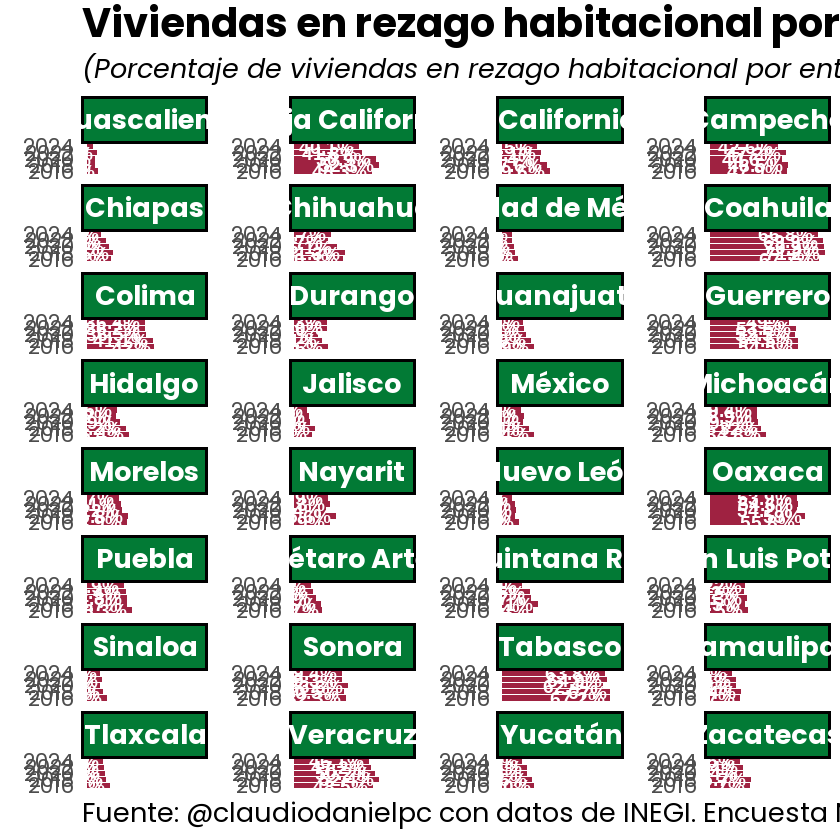

In [89]:
rezago_entidad %>%
  mutate(year = factor(year, levels = sort(unique(year), decreasing = FALSE)))%>%
  ggplot(aes(x = year, y = pct)) +
  geom_col(fill = "#9F2241") +
  coord_flip() +
  # Etiquetas al final de la barra
  geom_text(
    aes(label = paste0(round(pct, 1), "%")),
    hjust = 1.1,
    size = 5,
    color = "white",
    fontface = "bold"
  ) +


  theme_minimal() +
  theme(
    text = element_text(family = "pop"),
    axis.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 16),
    legend.title = element_blank(),
    panel.background = element_blank(),
    panel.border = element_blank(),
    strip.text.x = element_text(size = 20, color = "white", face = "bold"),
    strip.background = element_rect(color = "black", fill = "#027a35", size = 1.5),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank(),
    plot.title = element_text(size = 30, hjust = 0, face = "bold"),
    plot.subtitle = element_text(size = 20, hjust = 0, face = "italic"),
    plot.caption = element_text(size = 20, hjust = 0)
  ) +
  labs(
    title = "Viviendas en rezago habitacional por entidad federativa,2016-2022",
    subtitle = "(Porcentaje de viviendas en rezago habitacional por entidad federativa)",
    caption = "Fuente: @claudiodanielpc con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2024."
  ) +
  facet_wrap(~nom_ent, scales = "free_y", ncol = 4)

ggsave("rezago_entidad.png", width =45, height = 25, bg = "white", dpi = 80)